 **Data Preparation**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier 

# Data prepping
from sklearn.preprocessing import LabelEncoder

print("Libraries imported.")

Libraries imported.


In [ ]:
data = pd.read_csv('/content/globalterrorismdb_0617dist.csv', encoding='ISO-8859-1')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Data Selection 

In [ ]:
data_columns = [ 
    'eventid',
    'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    'extended', 'vicinity','crit1', 'crit2', 'crit3', 
    'doubtterr','multiple','success','suicide',
    'claimed','property','ishostkid',
    'nkill', 'nwound', 
    'country_txt','region','region_txt','attacktype1_txt','targtype1_txt', 
    'natlty1_txt','weaptype1_txt', 
    'target1','gname', 'summary']

**Cleaning the Data**

In [ ]:
data = data.loc[:, data_columns] 


data = data[(data.crit1 == 1) & (data.crit2 == 1) & (data.crit3 == 1) & (data.doubtterr == 0)]


data.weaptype1_txt.replace(
    'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)',
    'Vehicle', inplace = True)


data.iloc[:,[6, 15, 16, 17]] = data.iloc[:,[6, 15, 16, 17]].replace(-9,0)


data.claimed.replace(2,1, inplace = True)


data.target1 = data.target1.str.lower()
data.gname = data.gname.str.lower()
data.summary = data.summary.str.lower()    
data.target1 = data.target1.fillna('unknown').replace('unk','unknown')


data.nkill = np.round(data.nkill.fillna(data.nkill.median())).astype(int) 
data.nwound = np.round(data.nwound.fillna(data.nwound.median())).astype(int) 

data['ncasualties'] = data['nkill'] + data['nwound']
data['has_casualties'] = data['ncasualties'].apply(lambda x: 0 if x == 0 else 1)

print("Data cleaned and prepared.")

Data cleaned and prepared.


**Data exploration**

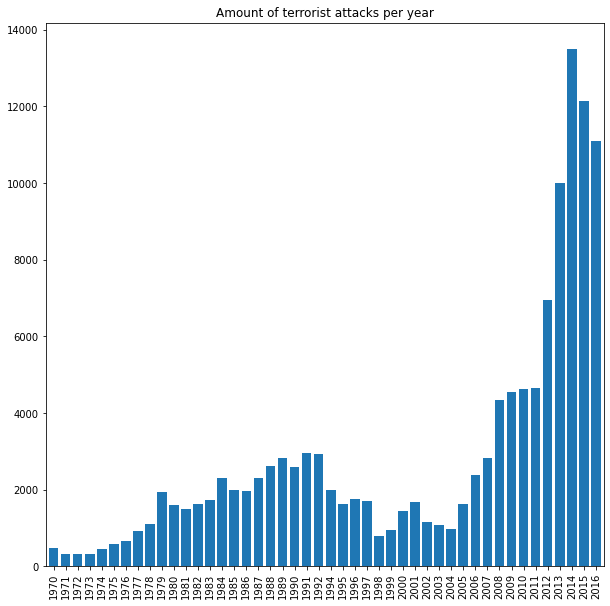

In [ ]:
barplot = pd.value_counts(data['iyear'])\
.sort_index()\
.plot\
.bar(width=0.8, figsize=(10, 10), title="Amount of terrorist attacks per year")

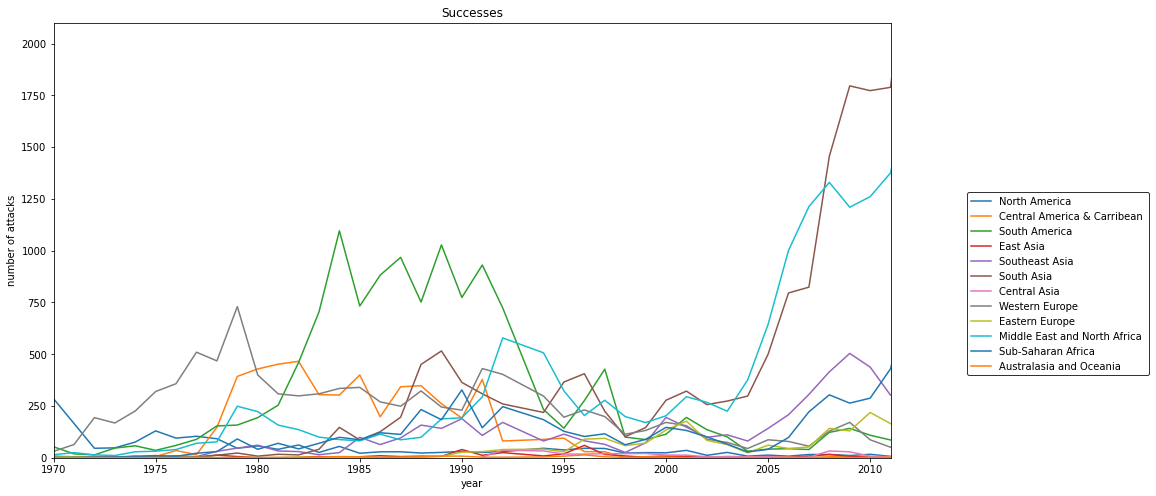

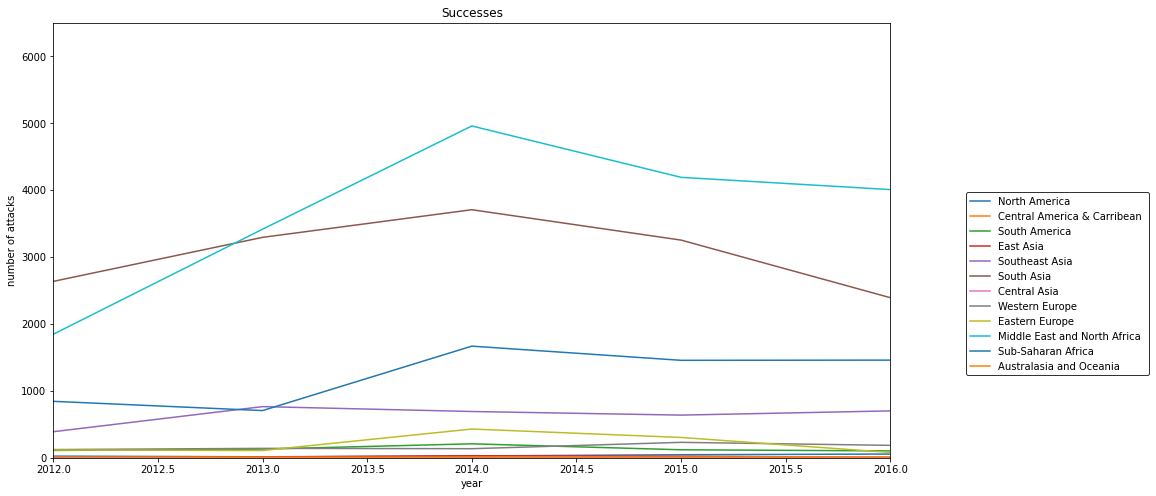

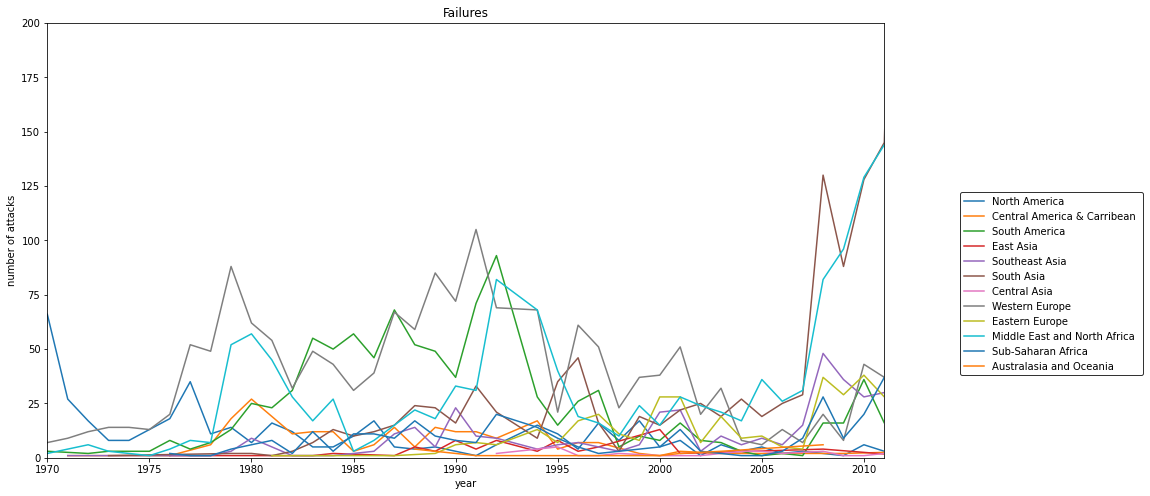

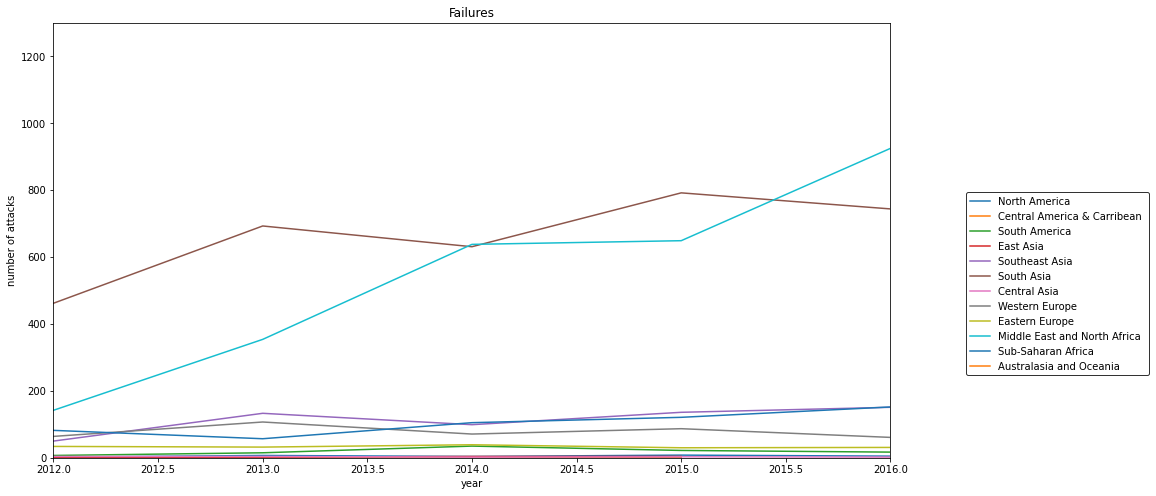

In [ ]:
region_dictionary = {1: 'North America', 2: 'Central America & Carribean', 3: 'South America',
                     4: 'East Asia', 5: 'Southeast Asia', 6: 'South Asia', 7: 'Central Asia',
                     8: 'Western Europe', 9: 'Eastern Europe', 10: 'Middle East and North Africa',
                     11: 'Sub-Saharan Africa', 12: 'Australasia and Oceania'}

def multi_graph(result,result_list, xmin, xmax, ymin, ymax):
    fig2, ax2 = plt.subplots(figsize = (15,8))
    number = 1 #the for-loop in append_list processes the regions in order from 1 to 12
    for j in result_list:
        ax2.plot(j.index, j.eventid, label = '%s ' % region_dictionary[number] )
        number += 1

    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    plt.xlabel('year')
    plt.ylabel('number of attacks')
    plt.title(result)
    ax2.legend(loc = 'center', frameon = True, edgecolor = 'black',bbox_to_anchor =(1.2,0.4))


success_list = []
failure_list = []

for i in region_dictionary:
    region_data = data[(data.region == i)]
    region_data_success = region_data[(region_data.success == 1)]
    region_data_failure = region_data[(region_data.success == 0)]
    region_grouped_success = region_data_success.groupby('iyear').count()
    region_grouped_failure = region_data_failure.groupby('iyear').count()

    
    success_list.append(region_grouped_success)
    failure_list.append(region_grouped_failure)

multi_graph('Successes',success_list, 1970, 2011, 0, 2100)
multi_graph('Successes',success_list, 2012, 2016, 0, 6500)
multi_graph('Failures',failure_list, 1970, 2011, 0, 200)
multi_graph('Failures',failure_list, 2012, 2016, 0, 1300)

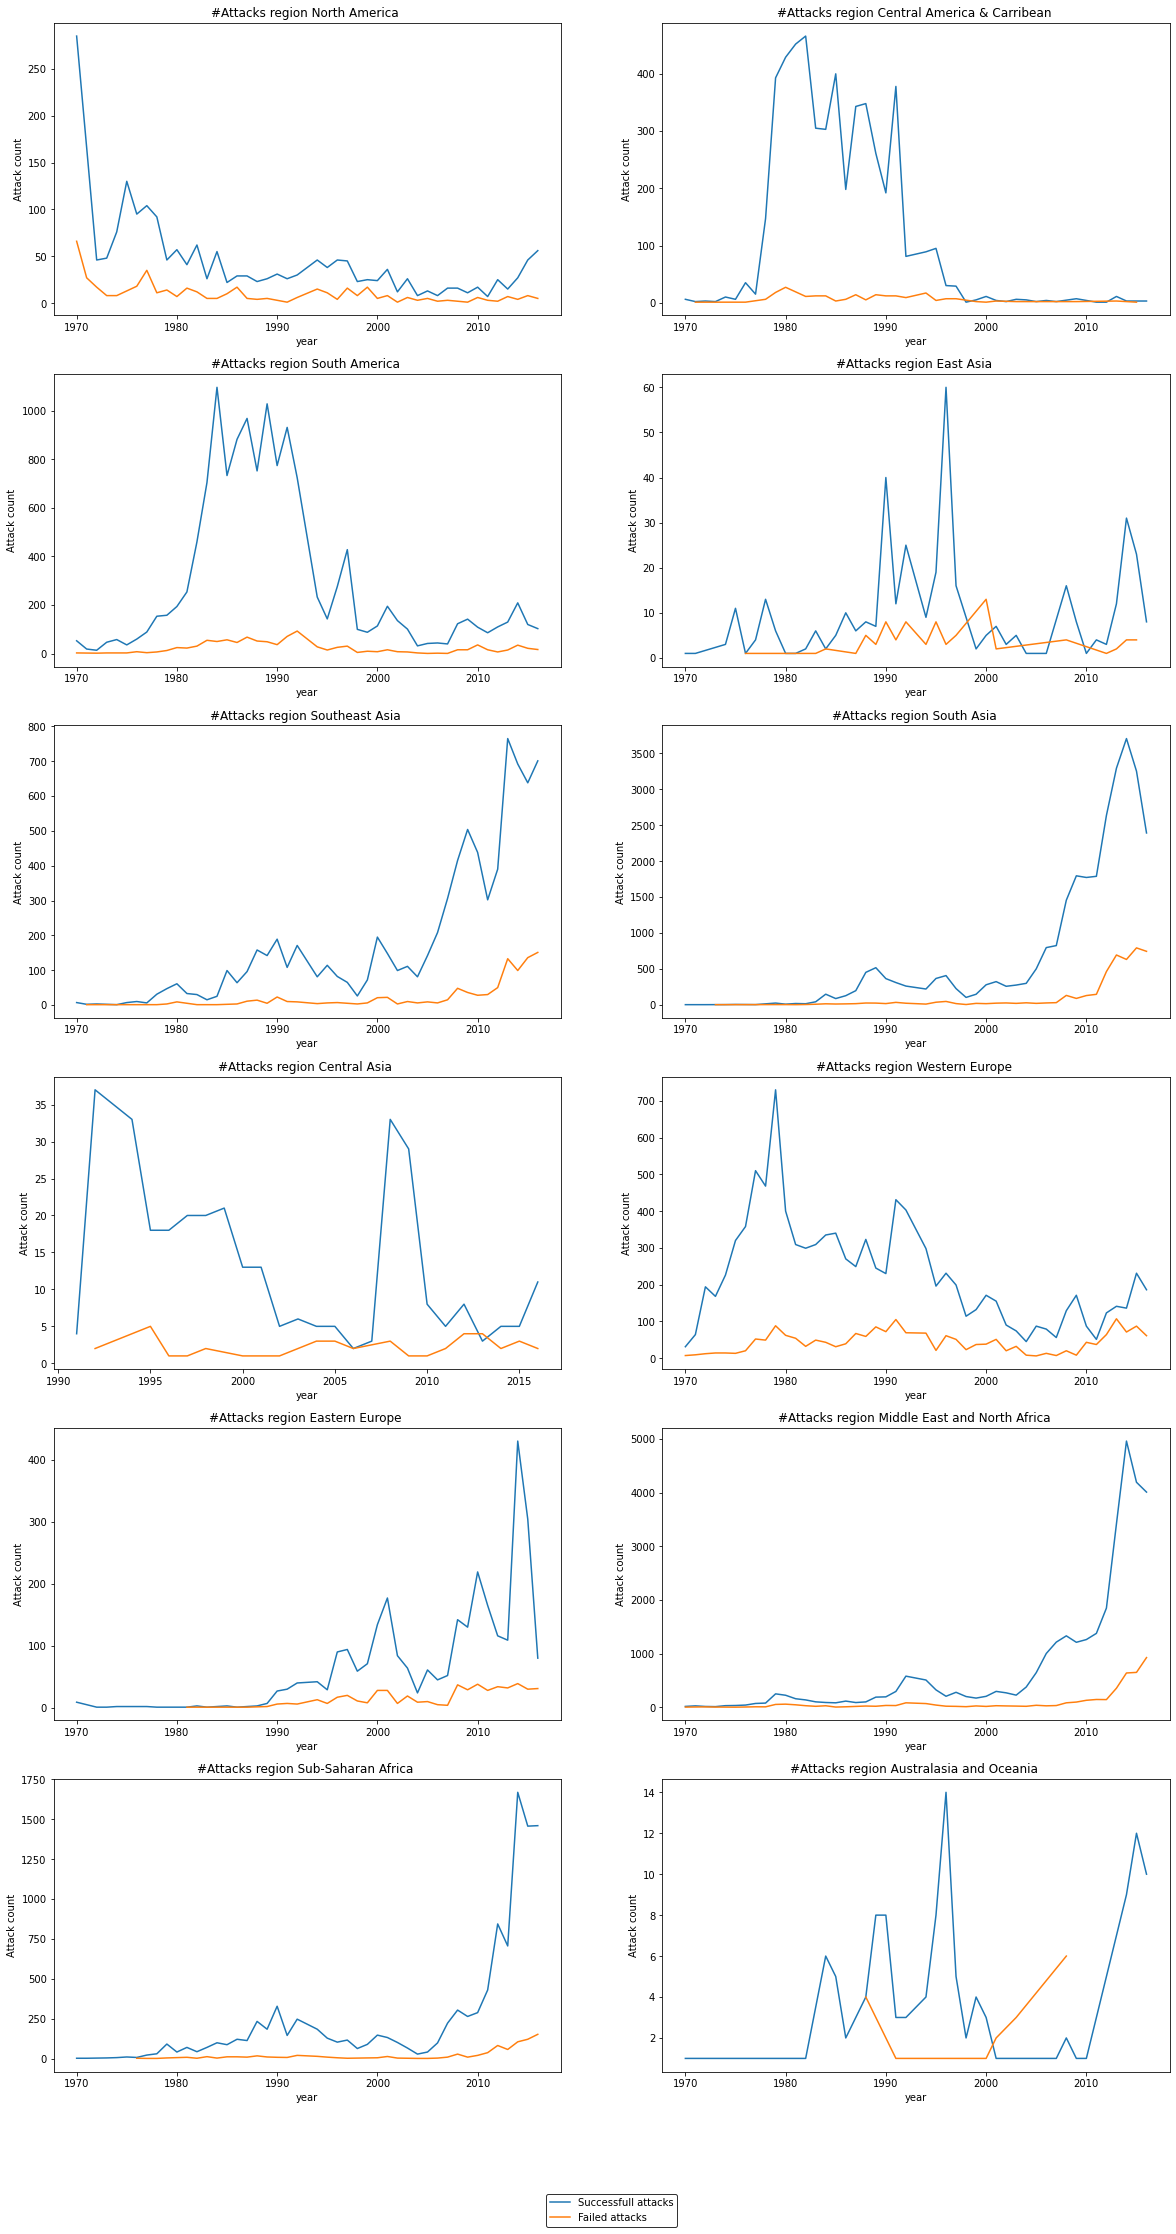

In [ ]:
def generate_graph(by_region_list):
    fig = plt.figure(figsize=(20,70))
    i = 1
    
    for element in by_region_list:
        ax1 = fig.add_subplot(11,2,i)
        ax1.set(title = '#Attacks region %s ' % region_dictionary[element[2]],
                ylabel = 'Attack count', xlabel = 'year')

        #entering data
        ax1.plot(element[0].index, element[0].eventid, label = 'Successfull attacks' )
        ax1.plot(element[1].index, element[1].eventid, label = 'Failed attacks' )
        
        i+=1
    
    #add legend
    ax1.legend(loc = 'upper center', frameon = True, edgecolor = 'black', bbox_to_anchor =(-0.1,-0.4))
    plt.show()  


def by_region():
        for region_number in region_dictionary:
            region_data = data[(data.region == region_number)] #for each region group data by year
            region_grouped_success = region_data[(region_data.success == 1)].groupby('iyear').count() #filter on success and group by year
            region_grouped_failure = region_data[(region_data.success == 0)].groupby('iyear').count() #filter on failure and group by year
            
            by_region_list.append([region_grouped_success, region_grouped_failure, region_number])
        
        #create line plot for region grouped by year
        generate_graph(by_region_list)

by_region_list = []
by_region()

In [ ]:
from mpl_toolkits.basemap import Basemap

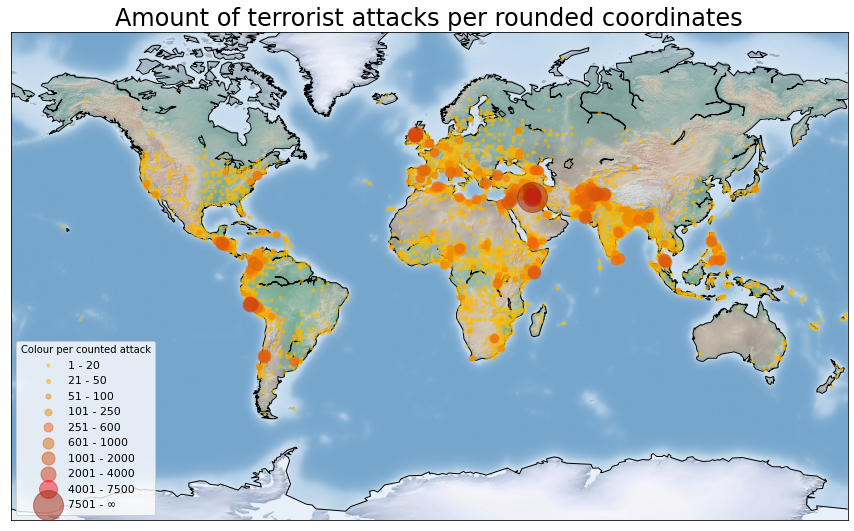

In [ ]:
orange_palette = ((3, 0, '#FBBC00', '1 - 20'), (4, 20, '#FDA600', '21 - 50'), (5, 50, '#EE8904', '51 - 100'), \
                  (7, 100, '#ED9001', '101 - 250'), (9, 250, '#ED6210', '251 - 600'), \
                  (11, 600, '#DE6D0A', '601 - 1000'), (13, 1000, '#D8510F', '1001 - 2000'), \
                  (15, 2000, '#D23711', '2001 - 4000'), (18, 4000, '#F61119', '4001 - 7500'), \
                  (30, 7500, '#9C200A', '7501 - ∞')) #marker size, count size, color

plt.figure(figsize=(15,15))
# Rounds the long- and latitude to a number withouth decimals, groups them on long- and latitude and counts the amount of attacks.
df_coords = data.round({'longitude':0, 'latitude':0}).groupby(["longitude", "latitude"]).size().to_frame(name = 'count').reset_index()
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
m.drawcoastlines()
m.shadedrelief()
    
def plot_points(marker_size, count_size, colour, label_count):
    x, y = m(list(df_coords.longitude[df_coords['count'] >= count_size].astype("float")),\
                (list(df_coords.latitude[df_coords['count'] >= count_size].astype("float"))))
    points = m.plot(x, y, "o", markersize = marker_size, color = colour, label = label_count, alpha = .5)

for p in orange_palette:
    plot_points(p[0], p[1], p[2], p[3]) 
    
plt.title("Amount of terrorist attacks per rounded coordinates", fontsize=24)
plt.legend(title= 'Colour per counted attack', loc ='lower left', prop= {'size':11})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Amount of terrorist attacks per rounded coordinates')

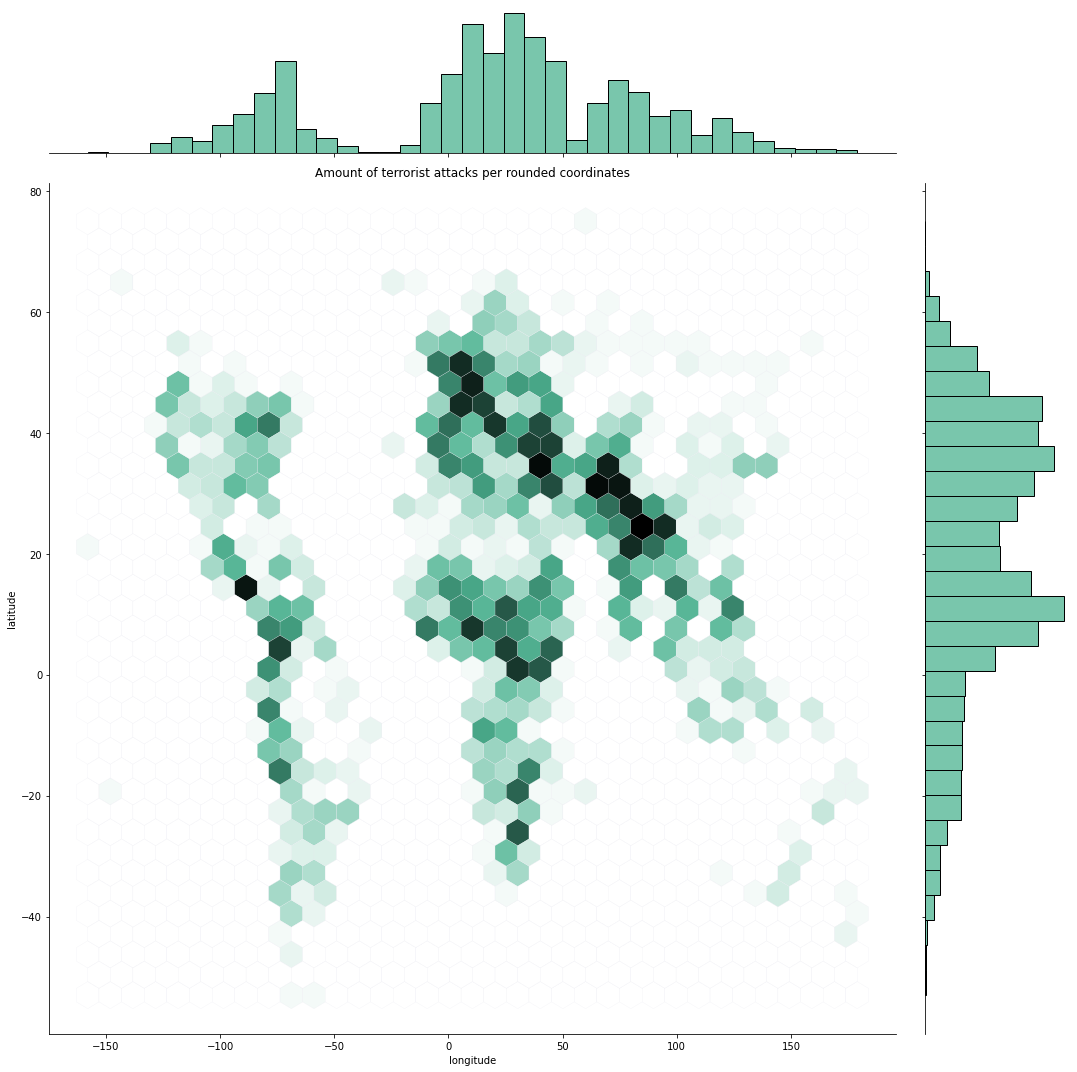

In [ ]:
sns.jointplot(x='longitude', y='latitude', data=df_coords, kind="hex", color="#4CB391", size=15 , edgecolor="#EAEAF2", linewidth=.2)
plt.title('Amount of terrorist attacks per rounded coordinates')

Text(0, 0.5, 'Attack type')

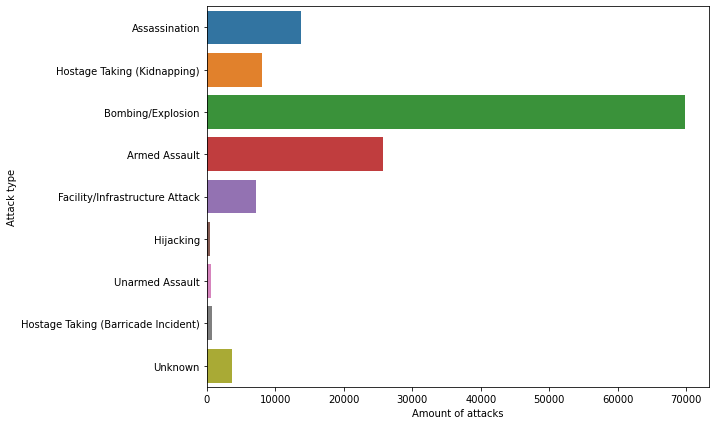

In [ ]:
plt.figure(figsize=(9,7))
ax = sns.countplot(y="attacktype1_txt", data=data)
ax.set_xlabel("Amount of attacks")
ax.set_ylabel("Attack type")

In [ ]:
data_w = pd.read_csv('/content/terrorist_weather_jan2012_dec_2016.csv', encoding='ISO-8859-1')

In [ ]:
data_w.head()

,iyear,imonth,iday,latitude,longitude,extended,vicinity,crit1,crit2,crit3,...,target1,gname,summary,ncasualties,has_casualties,t2m,tcc,vidgf,sp,v10
0,2012,1,1,30.209423,67.018009,0,0,1,1,1,...,paan shop,unknown,01/01/2012: a grenade was thrown into a shop o...,12,1,288.217098,9.998669e-13,-366.496179,101457.723797,-3.828428
1,2012,1,1,-0.456120,39.646123,0,0,1,1,1,...,bar,al-shabaab,01/01/2012: assailants threw two grenades and ...,17,1,297.077670,1.530221e-01,606.077234,101103.215653,1.320113
2,2012,1,1,-0.456120,39.646123,0,0,1,1,1,...,bar,al-shabaab,01/01/2012: assailants threw a grenade and ope...,16,1,297.077670,1.530221e-01,606.077234,101103.215653,1.320113
3,2012,1,1,28.466667,67.283333,1,0,1,1,1,...,civilians,unknown,01/01/2012: four men were kidnapped from their...,0,0,287.513173,9.998669e-13,-17.655798,100755.508624,-3.728933
4,2012,1,1,34.761723,71.324719,0,0,1,1,1,...,militia members,unknown,01/01/2012: an explosive device targeting anti...,4,1,269.929184,9.998669e-13,62.722170,79226.577609,0.577216


In [ ]:
X = data_w[['t2m', 'tcc', 'vidgf', 'sp', 'v10']].fillna(0) # Features
y = data_w['has_casualties'].fillna(0) # Target

X.shape, y.shape

((53715, 5), (53715,))

In [ ]:
y.value_counts()

1    36396
0    17319
Name: has_casualties, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Use SVM as classifier.
model = svm.SVC()

# Fit the model with training sets.
%time model.fit(X_train, y_train)

# Predict wether there are casualties or not.
%time y_pred = model.predict(X_test)

CPU times: user 47.7 s, sys: 77.3 ms, total: 47.8 s
Wall time: 49 s
CPU times: user 22.6 s, sys: 0 ns, total: 22.6 s
Wall time: 22.5 s


In [ ]:
np.mean(y_pred == y_test)

0.6814148309028855

In [ ]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
model = DummyClassifier(strategy="most_frequent")

print("Fitting time")
%time model.fit(X_train, y_train)
print(" ")
print("Predictiong time")
%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

Fitting time
CPU times: user 5.96 ms, sys: 0 ns, total: 5.96 ms
Wall time: 8.33 ms
 
Predictiong time
CPU times: user 0 ns, sys: 571 µs, total: 571 µs
Wall time: 585 µs


0.584011083459476

In [ ]:
feature_cols = [
    'iyear', 'imonth', 'iday', 'latitude', 'longitude',
    
                'extended',
                'vicinity',
                'doubtterr',
                'multiple',
                'success',
                'suicide',
                'claimed',
                'property',
                'ishostkid',
    
                'country_txt',
                'region',
                'attacktype1_txt',
                'targtype1_txt',
                'weaptype1_txt',
]

# Target is a binary value: were there any casualties in the attack?
target_col = 'has_casualties'

lb = LabelEncoder()
data['country_txt'] = lb.fit_transform(data['country_txt'])
data['attacktype1_txt'] = lb.fit_transform(data['attacktype1_txt'])
data['targtype1_txt'] = lb.fit_transform(data['targtype1_txt'])
data['weaptype1_txt'] = lb.fit_transform(data['weaptype1_txt'])

# Define X and Y.
X = data[feature_cols].fillna(0)
y = data[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

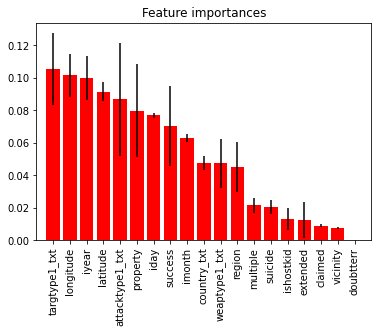

In [ ]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
fnames = [feature_cols[i] for i in indices]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), fnames, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
feature_cols = ['longitude', 'targtype1_txt', 'latitude', 'attacktype1_txt', 'property', 'iday', 'imonth']

X = data[feature_cols].fillna(0) # Assign chosen features to X.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
model = RandomForestClassifier(n_estimators=20)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

0.8128383405598173

Confusion matrix, without normalization
[[12539  3743]
 [ 3552 19143]]
Normalized confusion matrix
[[0.77 0.23]
 [0.16 0.84]]


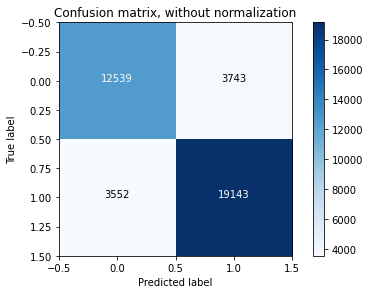

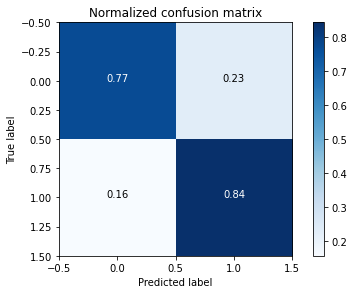

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
 

def plot_confusion_matrix(cm,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 
# Compute confusion matrix
np.set_printoptions(precision=2)
 
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix,
                      title='Confusion matrix, without normalization')
 
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized confusion matrix')
 
plt.show()

In [ ]:
# Better validation with K-fold.
model = RandomForestClassifier(n_estimators=20)

scores = cross_val_score(model, X, y, cv=10) # Ten-fold cross validation.
print(scores)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

[0.43400292 0.16632033 0.30334052 0.41248461 0.31026786 0.46998153
 0.53309729 0.75608067 0.80033867 0.83335899]
Accuracy: 0.50 (+/- 0.43)


In [ ]:
# Simply predict the most frequent value every time.
# This determines the baseline accuracy.
model = DummyClassifier(strategy="most_frequent")

%time model.fit(X_train, y_train)

%time y_pred = model.predict(X_test)

np.mean(y_pred == y_test)

CPU times: user 6.54 ms, sys: 21 µs, total: 6.56 ms
Wall time: 25.2 ms
CPU times: user 610 µs, sys: 0 ns, total: 610 µs
Wall time: 621 µs


0.584011083459476

In [ ]:
data.shape

(129922, 32)

In [ ]:
data.head()

,eventid,iyear,imonth,iday,latitude,longitude,extended,vicinity,crit1,crit2,...,region_txt,attacktype1_txt,targtype1_txt,natlty1_txt,weaptype1_txt,target1,gname,summary,ncasualties,has_casualties
0,197000000001,1970,7,2,18.456792,-69.951164,0,0,1,1,...,Central America & Caribbean,1,13,Dominican Republic,10,julio guzman,mano-d,NaN,1,1
1,197000000002,1970,0,0,19.432608,-99.133207,0,0,1,1,...,North America,6,5,Belgium,10,"nadine chaval, daughter",23rd of september communist league,NaN,0,0
2,197001000001,1970,1,0,15.478598,120.599741,0,0,1,1,...,Southeast Asia,1,7,United States,10,employee,unknown,NaN,1,1
3,197001000002,1970,1,0,37.983773,23.728157,0,0,1,1,...,Western Europe,2,5,United States,2,u.s. embassy,unknown,NaN,0,0
5,197001010002,1970,1,1,37.005105,-89.176269,0,0,1,1,...,North America,0,12,United States,4,cairo police headquarters,black nationalists,1/1/1970: unknown african american assailants ...,0,0
